Import needed libraries.

In [20]:
import pandas as pd
from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics
from sklearn.linear_model import BayesianRidge
from sklearn.metrics import r2_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import numpy as np
import re
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

1. Get the stemmed data.

In [21]:
# Use pandas to read the tsv file
words_df = pd.read_csv(r'labeledTrainData.tsv', sep = '\t')

In [22]:
# Check the top of the dataframe
words_df.head()

,id,sentiment,review
0,5814_8,1,With all this stuff going down at the moment w...
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,7759_3,0,The film starts with a manager (Nicholas Bell)...
3,3630_4,0,It must be assumed that those who praised this...
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...


In [23]:
# Create a new column, 'classification' with the values from applying text blob to the 'review' column
words_df['classification'] = words_df['review'].apply(lambda text: TextBlob(text).sentiment)

In [24]:
# Check the top of the dataframe
words_df.head()

,id,sentiment,review,classification
0,5814_8,1,With all this stuff going down at the moment w...,"(0.001276742581090417, 0.6067460317460317)"
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi...","(0.2563492063492064, 0.5311111111111111)"
2,7759_3,0,The film starts with a manager (Nicholas Bell)...,"(-0.05394123606889564, 0.5629331306990881)"
3,3630_4,0,It must be assumed that those who praised this...,"(0.1347530864197531, 0.4929012345679012)"
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...,"(-0.024841720779220786, 0.45981782106782115)"


In [25]:
# Create two new columns, 'polarity' and 'subjectivity', by splitting the tuples in the 'classification' column
words_df[['polarity', 'subjectivity']] = pd.DataFrame(words_df['classification'].tolist(), index = words_df.index)

In [26]:
# Check the top of the dataframe, we can see the two new columns
words_df.head()

,id,sentiment,review,classification,polarity,subjectivity
0,5814_8,1,With all this stuff going down at the moment w...,"(0.001276742581090417, 0.6067460317460317)",0.001277,0.606746
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi...","(0.2563492063492064, 0.5311111111111111)",0.256349,0.531111
2,7759_3,0,The film starts with a manager (Nicholas Bell)...,"(-0.05394123606889564, 0.5629331306990881)",-0.053941,0.562933
3,3630_4,0,It must be assumed that those who praised this...,"(0.1347530864197531, 0.4929012345679012)",0.134753,0.492901
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...,"(-0.024841720779220786, 0.45981782106782115)",-0.024842,0.459818


In [27]:
# Convert text in the review column into lowercase
words_df['review'] = words_df.review.str.lower()

In [28]:
# Check the top of the review column
words_df['review'].head()

0    with all this stuff going down at the moment w...
1    \the classic war of the worlds\" by timothy hi...
2    the film starts with a manager (nicholas bell)...
3    it must be assumed that those who praised this...
4    superbly trashy and wondrously unpretentious 8...
Name: review, dtype: object

In [29]:
# Remove punctuation and special characters
words_df['review'] = words_df['review'].str.replace(r'[^\w\s]+', '', regex = True)

In [30]:
# Check the top of the review column
words_df['review'].head()

0    with all this stuff going down at the moment w...
1    the classic war of the worlds by timothy hines...
2    the film starts with a manager nicholas bell g...
3    it must be assumed that those who praised this...
4    superbly trashy and wondrously unpretentious 8...
Name: review, dtype: object

In [31]:
# Exclude stopwords with Python's list comprehension and pandas.DataFrame.apply.
stop = stopwords.words('english')
words_df['review'] = words_df['review'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [32]:
words_df['review'].head()

0    stuff going moment mj ive started listening mu...
1    classic war worlds timothy hines entertaining ...
2    film starts manager nicholas bell giving welco...
3    must assumed praised film greatest filmed oper...
4    superbly trashy wondrously unpretentious 80s e...
Name: review, dtype: object

In [33]:
# Assign PorterStemmer() to an object
ps = PorterStemmer()

In [34]:
# Use .map to apply PorterStemmer() (ps) to the review column
words_df['review'] = words_df.review.str.lower().map(ps.stem)

In [35]:
# Check the top of the review column
words_df['review'].head()

0    stuff going moment mj ive started listening mu...
1    classic war worlds timothy hines entertaining ...
2    film starts manager nicholas bell giving welco...
3    must assumed praised film greatest filmed oper...
4    superbly trashy wondrously unpretentious 80s e...
Name: review, dtype: object

In [36]:
words_df['review'].astype(str)

0        stuff going moment mj ive started listening mu...
1        classic war worlds timothy hines entertaining ...
2        film starts manager nicholas bell giving welco...
3        must assumed praised film greatest filmed oper...
4        superbly trashy wondrously unpretentious 80s e...
                               ...                        
24995    seems like consideration gone imdb reviews fil...
24996    dont believe made film completely unnecessary ...
24997    guy loser cant get girls needs build picked st...
24998    30 minute documentary buñuel made early 1930s ...
24999    saw movie child broke heart story unfinished e...
Name: review, Length: 25000, dtype: object

In [37]:
stopwords_list = set(stopwords.words("english"))

In [38]:
re_negation = re.compile("n't ")

# function that receives a sequence of words and return the same sequence transforming abbrieviated negations to the standard form
def negation_abbreviated_to_standard(sent):
    sent = re_negation.sub(" not ", sent)
    return sent

In [39]:
lemmatizer = WordNetLemmatizer()

In [40]:
def lemma_stem_text(words_list):
    # Lemmatizer
    text = [lemmatizer.lemmatize(token.lower()) for token in words_list]# eighties->eight or messages->message or drugs->drug
    text = [lemmatizer.lemmatize(token.lower(), "v") for token in text]# going-> go or started->start or watching->watch
    return text

In [41]:
# Import function BeautifulSoup to clean text of HTML tags
def review_to_words(raw_review):
    # 1. Remove HTML tags
    review_text = BeautifulSoup(raw_review).get_text() 

    # 2. Transform abbreviated negations to the standard form.
    review_text = negation_abbreviated_to_standard(review_text)

    # 3. Remove non-letters and non-numbers   
    letters_numbers_only = re.sub("[^a-zA-Z_0-9]", " ", review_text) 

    # 4. Convert to lower case and split into individual words (tokenization)
    words = np.char.lower(letters_numbers_only.split())                             

    # 5. Remove stop words
    meaningful_words = [w for w in words if not w in stopwords_list]   

    # 6. Apply lemmatization function
    lemma_words = lemma_stem_text(meaningful_words)

    # 7. Join the words back into one string separated by space, and return the result.
    return( " ".join(lemma_words))   

2. Split this into a training and test set.

In [42]:
# output
y = words_df.sentiment

# input
x = words_df.drop('sentiment', axis = 1)

# splitting
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 123)

# print shapes of testing and training sets
print('Shape of Original Data: ', words_df.shape)
print('Shape of Input - Training Set: ', x_train.shape)
print('Shape of Output - Training Set: ', y_train.shape)
print('Shape of Input - Testing Set: ', x_test.shape)
print('Shape of Output - Testing Set: ', y_test.shape)

Shape of Original Data:  (25000, 6)
Shape of Input - Training Set:  (20000, 5)
Shape of Output - Training Set:  (20000,)
Shape of Input - Testing Set:  (5000, 5)
Shape of Output - Testing Set:  (5000,)


In [43]:
# Clean first review
clean_review = review_to_words(x_train['review'][0] )

# Print original review, sentiment and cleaned review
print(f'Text of original review:\n{x_train["review"][0]}\n')
print(f'Sentiment review: {y_train[0]}\n')
print(f'Text of cleaned review:\n{clean_review}') 

Text of original review:
stuff going moment mj ive started listening music watching odd documentary watched wiz watched moonwalker maybe want get certain insight guy thought really cool eighties maybe make mind whether guilty innocent moonwalker part biography part feature film remember going see cinema originally released subtle messages mjs feeling towards press also obvious message drugs bad mkaybr br visually impressive course michael jackson unless remotely like mj anyway going hate find boring may call mj egotist consenting making movie mj fans would say made fans true really nice himbr br actual feature film bit finally starts 20 minutes excluding smooth criminal sequence joe pesci convincing psychopathic powerful drug lord wants mj dead bad beyond mj overheard plans nah joe pescis character ranted wanted people know supplying drugs etc dunno maybe hates mjs musicbr br lots cool things like mj turning car robot whole speed demon sequence also director must patience saint came fi

3. Fit and apply the tf-idf vectorization to the training set.

In [44]:
# Initialize an empty list to add the cleaned reviews to
cleaned_train_reviews = []
def clean_train_reviews(cleaned_train_reviews):
    # Get the text of the reviews in the training set
    reviews = x_train['review']
    # Loop over each review and clean it
    for i in reviews:
        cleaned_train_reviews.append(review_to_words(i))
    return cleaned_train_reviews

In [45]:
clean_train_reviews(cleaned_train_reviews)

['shift outlook neccesary enjoy modern british film one somehow allow see right quality rather criterion american film judge britfilm try hard gritty find hard make warmth british film lord otherwise overwhelm competitorbr br film fail content attach predeccesor allow easily see work star director somewhere near end tether couple decade later gregory teach time two girl mind teach school rail human right abuse student he fire find abuse midst must face whether he talkbr br subversive film there usual worldly character american movie expect whatever naive man boy may still put everything line principle maybe certainly protestbynumbers though warm u film may seem realistic theyre urban gritty british film recent year dont try match america visceral thrill real british humour reveal truth',
 'wow uhmwellwow guess ill start plot betroth woman lucy arrive family home would husband mathurin france await arrival bishop cardinal someone catholic church marry satisfy wait young lucy learn legen

In [46]:
# Assign the vectorizer method to the variable: vectorizer
vectorizer = TfidfVectorizer(max_features = 20000, ngram_range = (1,2))
# Create the training set with the words encoded as features of the reviews
train_data_features = vectorizer.fit_transform(cleaned_train_reviews)

In [47]:
train_data_features.shape

(20000, 20000)

4. Apply but DO NOT FIT the tf-idf vectorization to the test set.

In [48]:
# Initialize an empty list to add the cleaned reviews to
cleaned_test_reviews = []
def clean_test_reviews(cleaned_test_reviews):
    # Get the text of the reviews in the training set
    reviews = x_test['review']
    # Loop over each review and clean it
    for i in reviews:
        cleaned_test_reviews.append(review_to_words(i))
    return cleaned_test_reviews

In [49]:
clean_test_reviews(cleaned_test_reviews)

['watch couple laugh nothing write home jason lee look like fun long dvd gag reel consist almost solely fit uncontrollable laughter selma blair seem punch time clock character suppose stick mud well do guess jim brolin surprisingly funny marry babs cant picnic soundtrack hip eclectic larry miller play julia stile father hilariously 10 thing hate funny well he great best aspect movie cast julia stile could spend two hour watch fold laundry feel lik',
 'youre research ufo fact video important meat video comment make buzz aldrin without doubt best america train objective honest factual report many astronaut america era report kind contact ufo observance video mission least something happen require objective ongoing investigate think testimony buzz aldrin show possible world may interest progress like suppose documentary video one may slant contain information opinion accomplish american hero dont come along every day fact people arent interest detail detour view video nothing else interes

In [50]:
# Create the test set with the words encoded as features of the reviews
test_data_features = vectorizer.transform(cleaned_test_reviews)

print(test_data_features.shape)

(5000, 20000)


If you use fit_transform as with the feature matrix above (calculated with training and test subsets combined), when you're training the model it could lead to data leakage and cause performance measures to be too optimistic.

5. Train a logistic regression using the training data.

In [51]:
# Define the model
model = LogisticRegression(random_state = 0, solver = 'lbfgs', multi_class = 'multinomial')
# Train model
model.fit(train_data_features, y_train)

LogisticRegression(multi_class='multinomial', random_state=0)

In [52]:
# Use the logistic regression model to make sentiment label predictions
result = model.predict(test_data_features)

In [53]:
output = pd.DataFrame(data = {'id':x_test['id'], 'sentiment':result})

In [54]:
output

,id,sentiment
20000,3862_4,1
5515,6986_8,1
966,7811_2,0
22726,11454_4,0
2690,10278_1,0
...,...,...
17399,12331_2,0
6965,12025_1,0
20230,5898_8,1
19078,9774_8,1


6. Find the model accuracy on test set.

In [55]:
model.predict_proba(test_data_features)

array([[0.29947447, 0.70052553],
       [0.46882703, 0.53117297],
       [0.96313426, 0.03686574],
       ...,
       [0.21965844, 0.78034156],
       [0.16680644, 0.83319356],
       [0.09337434, 0.90662566]])

In [56]:
model.predict(test_data_features)

array([1, 1, 0, ..., 1, 1, 1], dtype=int64)

In [57]:
y_pred = model.predict(test_data_features)
print("Accuracy: ", round(metrics.accuracy_score(y_test,y_pred),3))
print("F1: ", round(metrics.f1_score(y_test, y_pred),3))

Accuracy:  0.894
F1:  0.896


7. Create a confusion matrix for the test set predictions.

In [58]:
cm = metrics.confusion_matrix(y_test, y_pred)

In [59]:
cm

array([[2178,  290],
       [ 242, 2290]], dtype=int64)

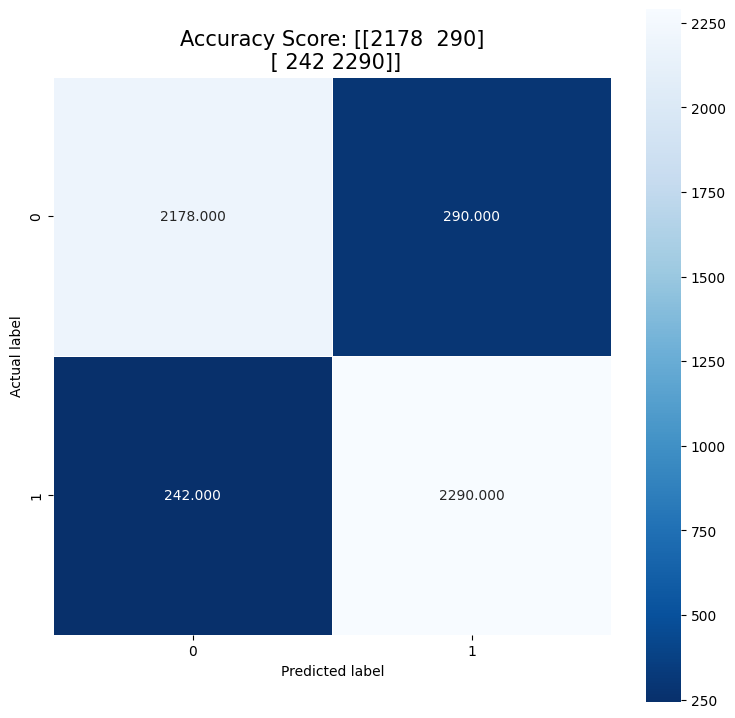

In [60]:
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot = True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(cm)
plt.title(all_sample_title, size = 15);

8. Get the precision, recall, and F1-score for the test set predictions.

In [61]:
print('Precision: %.3f' % metrics.precision_score(y_test, y_pred))
print('Recall: %.3f' % metrics.recall_score(y_test, y_pred))
print('F1 Score: %.3f' % metrics.f1_score(y_test, y_pred))

Precision: 0.888
Recall: 0.904
F1 Score: 0.896


9. Create a ROC curve for the test set.

In [62]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)

In [63]:
print('FPR: ', fpr)
print('TPR: ', tpr)
print('Thresholds: ', thresholds)

FPR:  [0.         0.11750405 1.        ]
TPR:  [0.         0.90442338 1.        ]
Thresholds:  [inf  1.  0.]


A new model.

5. Train a decision tree classifier using the training data.

In [64]:
from sklearn.tree import DecisionTreeClassifier as dtc

In [65]:
decisiontree = dtc(random_state = 0)

In [66]:
tree_model = decisiontree.fit(train_data_features, y_train)

In [67]:
tree_model.predict(test_data_features)

array([0, 0, 0, ..., 0, 1, 0], dtype=int64)

6. Find the model accuracy on test set.

In [68]:
tree_model.predict_proba(test_data_features)

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [0., 1.],
       [1., 0.]])

In [69]:
y_pred = tree_model.predict(test_data_features)
print("Accuracy: ", round(metrics.accuracy_score(y_test,y_pred),3))
print("F1: ", round(metrics.f1_score(y_test, y_pred),3))

Accuracy:  0.705
F1:  0.706


7. Create a confusion matrix for the test set predictions.

In [70]:
cm = metrics.confusion_matrix(y_test, y_pred)

In [71]:
cm

array([[1756,  712],
       [ 763, 1769]], dtype=int64)

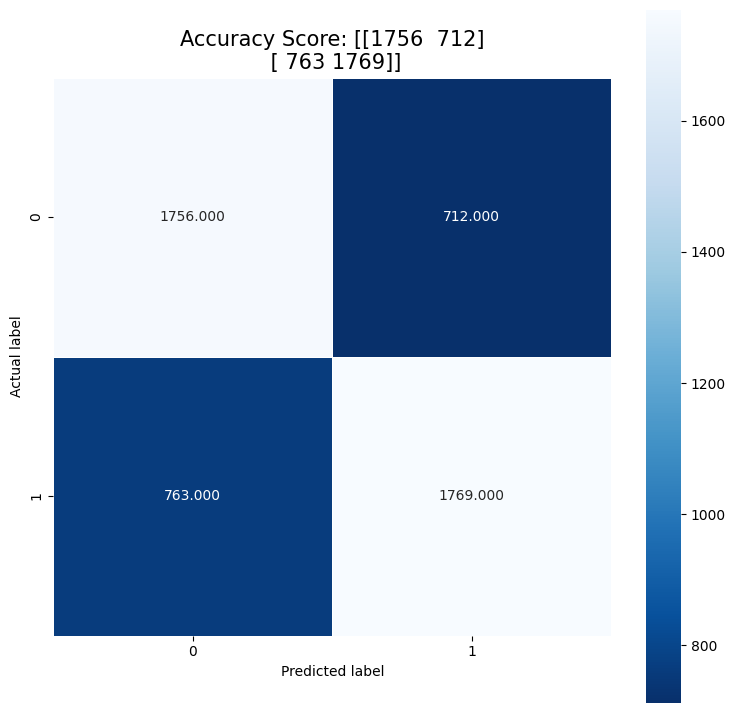

In [72]:
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot = True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(cm)
plt.title(all_sample_title, size = 15);

8. Get the precision, recall, and F1-score for the test set predictions.

In [73]:
print('Precision: %.3f' % metrics.precision_score(y_test, y_pred))
print('Recall: %.3f' % metrics.recall_score(y_test, y_pred))
print('F1 Score: %.3f' % metrics.f1_score(y_test, y_pred))

Precision: 0.713
Recall: 0.699
F1 Score: 0.706


9. Create a ROC curve for the test set.

In [74]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)

In [75]:
print('FPR: ', fpr)
print('TPR: ', tpr)
print('Thresholds: ', thresholds)

FPR:  [0.         0.28849271 1.        ]
TPR:  [0.         0.69865719 1.        ]
Thresholds:  [inf  1.  0.]
